In [2]:
import pandas as pd
import numpy as np
import librosa
import seaborn as sns
import os
import json
import IPython.display as ipd
import soundfile as sf
import math
import h5py
import torchaudio

from glob import glob
from tqdm import tqdm
from matplotlib import pyplot as plt
from itertools import chain
from os.path import join as pjoin
from shutil import copyfile
from copy import deepcopy

from code_base.utils import parallel_librosa_load, write_json, load_json
from code_base.models.blocks import TraceableMelspec
%matplotlib inline

/gpfs/helios/home/volodymyr1/src/bird_clef_2025/.venv/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


`speechbrain` was not imported
`LEAF` was not imported


/gpfs/helios/home/volodymyr1/src/bird_clef_2025/.venv/lib/python3.11/site-packages/nnAudio/Spectrogram.py:4: Warning: importing Spectrogram subpackage will be deprecated soon. You should import the feature extractor from the feature subpackage. See actual documentation.
  warnings.warn(


# Input Data

In [2]:
glob("/gpfs/space/projects/BetterMedicine/volodymyr1/exps/bird_clef_2025/birdclef_2025/*")

['/gpfs/space/projects/BetterMedicine/volodymyr1/exps/bird_clef_2025/birdclef_2025/recording_location.txt',
 '/gpfs/space/projects/BetterMedicine/volodymyr1/exps/bird_clef_2025/birdclef_2025/birdclef-2025.zip',
 '/gpfs/space/projects/BetterMedicine/volodymyr1/exps/bird_clef_2025/birdclef_2025/sample_submission.csv',
 '/gpfs/space/projects/BetterMedicine/volodymyr1/exps/bird_clef_2025/birdclef_2025/train.csv',
 '/gpfs/space/projects/BetterMedicine/volodymyr1/exps/bird_clef_2025/birdclef_2025/test_soundscapes',
 '/gpfs/space/projects/BetterMedicine/volodymyr1/exps/bird_clef_2025/birdclef_2025/taxonomy.csv',
 '/gpfs/space/projects/BetterMedicine/volodymyr1/exps/bird_clef_2025/birdclef_2025/train_soundscapes',
 '/gpfs/space/projects/BetterMedicine/volodymyr1/exps/bird_clef_2025/birdclef_2025/train_audio']

In [3]:
!cat /gpfs/space/projects/BetterMedicine/volodymyr1/exps/bird_clef_2025/birdclef_2025/recording_location.txt

Nature reserve "El Silencio" in the municipality of Yondó in the Middle Magdalena Valley of Colombia.

Website: https://www.fundacionbiodiversa.org/fundacion2024/information/  

Coordinates:

Latitude: 6.76
Longitude: -74.21

In [4]:
eBird_Taxonomy_v2021 = pd.read_csv("/gpfs/space/projects/BetterMedicine/volodymyr1/exps/bird_clef_2025/birdclef_2025/taxonomy.csv")
sample_submission = pd.read_csv("/gpfs/space/projects/BetterMedicine/volodymyr1/exps/bird_clef_2025/birdclef_2025/sample_submission.csv")
train_metadata = pd.read_csv("/gpfs/space/projects/BetterMedicine/volodymyr1/exps/bird_clef_2025/birdclef_2025/train.csv", converters={"secondary_labels":eval, "all_labels": eval})

In [5]:
train_metadata.head()

,primary_label,secondary_labels,type,filename,collection,rating,url,latitude,longitude,scientific_name,common_name,author,license
0,1139490,[],[''],1139490/CSA36385.ogg,CSA,0.0,http://colecciones.humboldt.org.co/rec/sonidos...,7.3206,-73.7128,Ragoniella pulchella,Ragoniella pulchella,Fabio A. Sarria-S,cc-by-nc-sa 4.0
1,1139490,[],[''],1139490/CSA36389.ogg,CSA,0.0,http://colecciones.humboldt.org.co/rec/sonidos...,7.3206,-73.7128,Ragoniella pulchella,Ragoniella pulchella,Fabio A. Sarria-S,cc-by-nc-sa 4.0
2,1192948,[],[''],1192948/CSA36358.ogg,CSA,0.0,http://colecciones.humboldt.org.co/rec/sonidos...,7.3791,-73.7313,Oxyprora surinamensis,Oxyprora surinamensis,Fabio A. Sarria-S,cc-by-nc-sa 4.0
3,1192948,[],[''],1192948/CSA36366.ogg,CSA,0.0,http://colecciones.humboldt.org.co/rec/sonidos...,7.2800,-73.8582,Oxyprora surinamensis,Oxyprora surinamensis,Fabio A. Sarria-S,cc-by-nc-sa 4.0
4,1192948,[],[''],1192948/CSA36373.ogg,CSA,0.0,http://colecciones.humboldt.org.co/rec/sonidos...,7.3791,-73.7313,Oxyprora surinamensis,Oxyprora surinamensis,Fabio A. Sarria-S,cc-by-nc-sa 4.0


In [6]:
eBird_Taxonomy_v2021.head()

,primary_label,inat_taxon_id,scientific_name,common_name,class_name
0,1139490,1139490,Ragoniella pulchella,Ragoniella pulchella,Insecta
1,1192948,1192948,Oxyprora surinamensis,Oxyprora surinamensis,Insecta
2,1194042,1194042,Copiphora colombiae,Copiphora colombiae,Insecta
3,126247,126247,Leptodactylus insularum,Spotted Foam-nest Frog,Amphibia
4,1346504,1346504,Neoconocephalus brachypterus,Neoconocephalus brachypterus,Insecta


In [8]:
scored_birds = sample_submission.columns[1:]
len(scored_birds)

206

In [9]:
train_metadata["primary_label"].isin(scored_birds).sum() / train_metadata.shape[0]

1.0

In [10]:
train_metadata["primary_label"].value_counts()

primary_label
grekis     990
compau     808
trokin     787
roahaw     709
banana     610
          ... 
476537       2
47067        2
42113        2
42087        2
1139490      2
Name: count, Length: 206, dtype: int64

In [11]:
train_metadata

,primary_label,secondary_labels,type,filename,collection,rating,url,latitude,longitude,scientific_name,common_name,author,license
0,1139490,[],[''],1139490/CSA36385.ogg,CSA,0.0,http://colecciones.humboldt.org.co/rec/sonidos...,7.3206,-73.7128,Ragoniella pulchella,Ragoniella pulchella,Fabio A. Sarria-S,cc-by-nc-sa 4.0
1,1139490,[],[''],1139490/CSA36389.ogg,CSA,0.0,http://colecciones.humboldt.org.co/rec/sonidos...,7.3206,-73.7128,Ragoniella pulchella,Ragoniella pulchella,Fabio A. Sarria-S,cc-by-nc-sa 4.0
2,1192948,[],[''],1192948/CSA36358.ogg,CSA,0.0,http://colecciones.humboldt.org.co/rec/sonidos...,7.3791,-73.7313,Oxyprora surinamensis,Oxyprora surinamensis,Fabio A. Sarria-S,cc-by-nc-sa 4.0
3,1192948,[],[''],1192948/CSA36366.ogg,CSA,0.0,http://colecciones.humboldt.org.co/rec/sonidos...,7.2800,-73.8582,Oxyprora surinamensis,Oxyprora surinamensis,Fabio A. Sarria-S,cc-by-nc-sa 4.0
4,1192948,[],[''],1192948/CSA36373.ogg,CSA,0.0,http://colecciones.humboldt.org.co/rec/sonidos...,7.3791,-73.7313,Oxyprora surinamensis,Oxyprora surinamensis,Fabio A. Sarria-S,cc-by-nc-sa 4.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
28559,ywcpar,[],[''],ywcpar/iNat77392.ogg,iNat,0.0,https://static.inaturalist.org/sounds/77392.m4a,7.6921,-80.3379,Amazona ochrocephala,Yellow-crowned Parrot,Yennifer Alfaro,cc-by-nc 4.0
28560,ywcpar,[],[''],ywcpar/iNat78624.ogg,iNat,0.0,https://static.inaturalist.org/sounds/78624.wav,8.9918,-79.4877,Amazona ochrocephala,Yellow-crowned Parrot,Evan Centanni,cc-by-nc-sa 4.0
28561,ywcpar,[],[''],ywcpar/iNat789234.ogg,iNat,0.0,https://static.inaturalist.org/sounds/789234.wav,9.2316,-70.2041,Amazona ochrocephala,Yellow-crowned Parrot,Henrry,cc-by 4.0
28562,ywcpar,[],[''],ywcpar/iNat819873.ogg,iNat,0.0,https://static.inaturalist.org/sounds/819873.mp3,10.5838,-66.8545,Amazona ochrocephala,Yellow-crowned Parrot,Alejandro Luy,cc-by-nc 4.0


In [12]:
sample_submission

,row_id,1139490,1192948,1194042,126247,1346504,134933,135045,1462711,1462737,...,yebfly1,yebsee1,yecspi2,yectyr1,yehbla2,yehcar1,yelori1,yeofly1,yercac1,ywcpar
0,soundscape_8358733_5,0.004854,0.004854,0.004854,0.004854,0.004854,0.004854,0.004854,0.004854,0.004854,...,0.004854,0.004854,0.004854,0.004854,0.004854,0.004854,0.004854,0.004854,0.004854,0.004854
1,soundscape_8358733_10,0.004854,0.004854,0.004854,0.004854,0.004854,0.004854,0.004854,0.004854,0.004854,...,0.004854,0.004854,0.004854,0.004854,0.004854,0.004854,0.004854,0.004854,0.004854,0.004854
2,soundscape_8358733_15,0.004854,0.004854,0.004854,0.004854,0.004854,0.004854,0.004854,0.004854,0.004854,...,0.004854,0.004854,0.004854,0.004854,0.004854,0.004854,0.004854,0.004854,0.004854,0.004854


In [13]:
train_metadata.columns

Index(['primary_label', 'secondary_labels', 'type', 'filename', 'collection',
       'rating', 'url', 'latitude', 'longitude', 'scientific_name',
       'common_name', 'author', 'license'],
      dtype='object')

In [35]:
train_metadata["collection"].value_counts()

collection
XC      21204
iNat     7198
CSA       162
Name: count, dtype: int64

In [39]:
train_metadata.loc[train_metadata["collection"] == "CSA", "url"].iloc[0]

'http://colecciones.humboldt.org.co/rec/sonidos/IAvH-CSA-36385/IAvH-CSA-36385.mp3'

# Enrich Meta

In [23]:
def get_audio_metadata(file_path: str):
    """
    Extract metadata from an audio file using torchaudio.
    
    Args:
        file_path (str): Path to the audio file.
    
    Returns:
        dict: Metadata containing sample rate, duration, channels, bit depth, and encoding format.
    """
    # Get basic metadata
    metadata = torchaudio.info(file_path)
    
    # Extract key information
    sample_rate = metadata.sample_rate
    num_channels = metadata.num_channels
    num_frames = metadata.num_frames
    duration = num_frames / sample_rate if sample_rate else None
    
    # Additional metadata (if available)
    bit_depth = getattr(metadata, "bits_per_sample", None)  # Only available for certain formats
    encoding = getattr(metadata, "encoding", None)  # Available for some formats
    
    return {
        "sample_rate": sample_rate,
        "duration_s": duration,
        "num_channels": num_channels,
        "bit_depth": bit_depth,
        "encoding": encoding,
    }

In [46]:
train_metadata["filename"].apply(lambda x: os.path.splitext(os.path.join(
    "/gpfs/space/projects/BetterMedicine/volodymyr1/exps/bird_clef_2025/birdclef_2025/train_audio",
    x
).replace("train_audio", "train_features"))[0] + ".hdf5").apply(os.path.exists).all()

True

In [25]:
audio_meta = pd.DataFrame(train_metadata["filename"].apply(lambda x: get_audio_metadata(os.path.join(
    "/gpfs/space/projects/BetterMedicine/volodymyr1/exps/bird_clef_2025/birdclef_2025/train_audio",
    x
))).to_list())

In [27]:
audio_meta["num_channels"].value_counts()

num_channels
1    28564
Name: count, dtype: int64

In [33]:
audio_meta["sample_rate"].value_counts()

sample_rate
32000    28564
Name: count, dtype: int64

<Axes: >

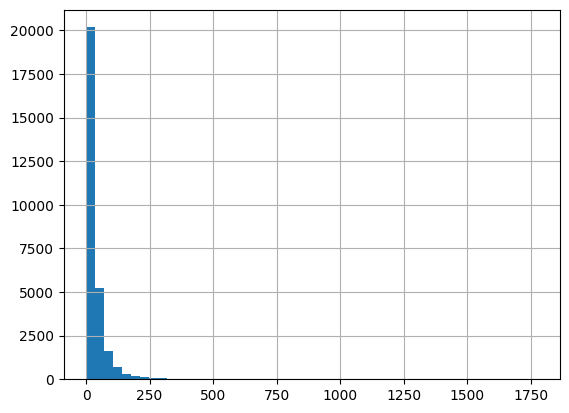

In [30]:
audio_meta["duration_s"].hist(bins=50)

In [31]:
train_metadata = pd.concat([train_metadata, audio_meta], axis=1)

In [41]:
train_metadata.to_csv(
    "/gpfs/space/projects/BetterMedicine/volodymyr1/exps/bird_clef_2025/birdclef_2025/train_extendedv1.csv", index=False
)

In [ ]:
librosa.load()

In [45]:
train_metadata

,primary_label,secondary_labels,type,filename,collection,rating,url,latitude,longitude,scientific_name,common_name,author,license,sample_rate,duration_s,num_channels,bit_depth,encoding
0,1139490,[],[''],1139490/CSA36385.ogg,CSA,0.0,http://colecciones.humboldt.org.co/rec/sonidos...,7.3206,-73.7128,Ragoniella pulchella,Ragoniella pulchella,Fabio A. Sarria-S,cc-by-nc-sa 4.0,32000,98.853375,1,0,VORBIS
1,1139490,[],[''],1139490/CSA36389.ogg,CSA,0.0,http://colecciones.humboldt.org.co/rec/sonidos...,7.3206,-73.7128,Ragoniella pulchella,Ragoniella pulchella,Fabio A. Sarria-S,cc-by-nc-sa 4.0,32000,96.537719,1,0,VORBIS
2,1192948,[],[''],1192948/CSA36358.ogg,CSA,0.0,http://colecciones.humboldt.org.co/rec/sonidos...,7.3791,-73.7313,Oxyprora surinamensis,Oxyprora surinamensis,Fabio A. Sarria-S,cc-by-nc-sa 4.0,32000,116.599812,1,0,VORBIS
3,1192948,[],[''],1192948/CSA36366.ogg,CSA,0.0,http://colecciones.humboldt.org.co/rec/sonidos...,7.2800,-73.8582,Oxyprora surinamensis,Oxyprora surinamensis,Fabio A. Sarria-S,cc-by-nc-sa 4.0,32000,105.446313,1,0,VORBIS
4,1192948,[],[''],1192948/CSA36373.ogg,CSA,0.0,http://colecciones.humboldt.org.co/rec/sonidos...,7.3791,-73.7313,Oxyprora surinamensis,Oxyprora surinamensis,Fabio A. Sarria-S,cc-by-nc-sa 4.0,32000,103.631469,1,0,VORBIS
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
28559,ywcpar,[],[''],ywcpar/iNat77392.ogg,iNat,0.0,https://static.inaturalist.org/sounds/77392.m4a,7.6921,-80.3379,Amazona ochrocephala,Yellow-crowned Parrot,Yennifer Alfaro,cc-by-nc 4.0,32000,3.392000,1,0,VORBIS
28560,ywcpar,[],[''],ywcpar/iNat78624.ogg,iNat,0.0,https://static.inaturalist.org/sounds/78624.wav,8.9918,-79.4877,Amazona ochrocephala,Yellow-crowned Parrot,Evan Centanni,cc-by-nc-sa 4.0,32000,7.659688,1,0,VORBIS
28561,ywcpar,[],[''],ywcpar/iNat789234.ogg,iNat,0.0,https://static.inaturalist.org/sounds/789234.wav,9.2316,-70.2041,Amazona ochrocephala,Yellow-crowned Parrot,Henrry,cc-by 4.0,32000,7.666656,1,0,VORBIS
28562,ywcpar,[],[''],ywcpar/iNat819873.ogg,iNat,0.0,https://static.inaturalist.org/sounds/819873.mp3,10.5838,-66.8545,Amazona ochrocephala,Yellow-crowned Parrot,Alejandro Luy,cc-by-nc 4.0,32000,27.036750,1,0,VORBIS


In [44]:
train_metadata.shape

(28564, 18)

In [42]:
(set(train_metadata["primary_label"]) | set(chain(*train_metadata["secondary_labels"]))) - set(scored_birds)

{''}

In [43]:
set(scored_birds)

{'1139490',
 '1192948',
 '1194042',
 '126247',
 '1346504',
 '134933',
 '135045',
 '1462711',
 '1462737',
 '1564122',
 '21038',
 '21116',
 '21211',
 '22333',
 '22973',
 '22976',
 '24272',
 '24292',
 '24322',
 '41663',
 '41778',
 '41970',
 '42007',
 '42087',
 '42113',
 '46010',
 '47067',
 '476537',
 '476538',
 '48124',
 '50186',
 '517119',
 '523060',
 '528041',
 '52884',
 '548639',
 '555086',
 '555142',
 '566513',
 '64862',
 '65336',
 '65344',
 '65349',
 '65373',
 '65419',
 '65448',
 '65547',
 '65962',
 '66016',
 '66531',
 '66578',
 '66893',
 '67082',
 '67252',
 '714022',
 '715170',
 '787625',
 '81930',
 '868458',
 '963335',
 'amakin1',
 'amekes',
 'ampkin1',
 'anhing',
 'babwar',
 'bafibi1',
 'banana',
 'baymac',
 'bbwduc',
 'bicwre1',
 'bkcdon',
 'bkmtou1',
 'blbgra1',
 'blbwre1',
 'blcant4',
 'blchaw1',
 'blcjay1',
 'blctit1',
 'blhpar1',
 'blkvul',
 'bobfly1',
 'bobher1',
 'brtpar1',
 'bubcur1',
 'bubwre1',
 'bucmot3',
 'bugtan',
 'butsal1',
 'cargra1',
 'cattyr',
 'chbant1',
 'chfma

In [47]:
len(scored_birds)

206

In [16]:
write_json(
    "/gpfs/space/projects/BetterMedicine/volodymyr1/exps/bird_clef_2025/birdclef_2025/sb_2024.json",
    scored_birds.to_list()
)

# Explore undersampled

In [3]:
train_metadata = pd.read_csv(
    "/gpfs/space/projects/BetterMedicine/volodymyr1/exps/bird_clef_2025/birdclef_2025/train_extendedv1.csv"
)
eBird_Taxonomy_v2021 = pd.read_csv("/gpfs/space/projects/BetterMedicine/volodymyr1/exps/bird_clef_2025/birdclef_2025/taxonomy.csv")
eBird_Taxonomy_v2021 = eBird_Taxonomy_v2021.merge(
    train_metadata[["primary_label", "collection"]].drop_duplicates("primary_label"),
    on="primary_label"
)
eBird_Taxonomy_v2021 = eBird_Taxonomy_v2021.merge(
    train_metadata["primary_label"].value_counts().reset_index(),
    on="primary_label"
)

In [7]:
eBird_Taxonomy_v2021[eBird_Taxonomy_v2021["count"] == 500]

,primary_label,inat_taxon_id,scientific_name,common_name,class_name,collection,count


In [8]:
eBird_Taxonomy_v2021

,primary_label,inat_taxon_id,scientific_name,common_name,class_name,collection,count
0,1139490,1139490,Ragoniella pulchella,Ragoniella pulchella,Insecta,CSA,2
1,1192948,1192948,Oxyprora surinamensis,Oxyprora surinamensis,Insecta,CSA,4
2,1194042,1194042,Copiphora colombiae,Copiphora colombiae,Insecta,CSA,3
3,126247,126247,Leptodactylus insularum,Spotted Foam-nest Frog,Amphibia,XC,6
4,1346504,1346504,Neoconocephalus brachypterus,Neoconocephalus brachypterus,Insecta,CSA,5
...,...,...,...,...,...,...,...
201,yehcar1,1432779,Milvago chimachima,Yellow-headed Caracara,Aves,XC,238
202,yelori1,9352,Icterus nigrogularis,Yellow Oriole,Aves,XC,60
203,yeofly1,16567,Tolmomyias sulphurescens,Yellow-olive Flycatcher,Aves,XC,525
204,yercac1,10359,Cacicus cela,Yellow-rumped Cacique,Aves,XC,302


In [36]:
train_metadata[train_metadata["collection"] == "CSA"].iloc[0]

primary_label                                                 1139490
secondary_labels                                                 ['']
type                                                             ['']
filename                                         1139490/CSA36385.ogg
collection                                                        CSA
rating                                                            0.0
url                 http://colecciones.humboldt.org.co/rec/sonidos...
latitude                                                       7.3206
longitude                                                    -73.7128
scientific_name                                  Ragoniella pulchella
common_name                                      Ragoniella pulchella
author                                              Fabio A. Sarria-S
license                                               cc-by-nc-sa 4.0
sample_rate                                                     32000
duration_s          

In [28]:
eBird_Taxonomy_v2021

,primary_label,inat_taxon_id,scientific_name,common_name,class_name,collection,count
0,1139490,1139490,Ragoniella pulchella,Ragoniella pulchella,Insecta,CSA,2
1,1192948,1192948,Oxyprora surinamensis,Oxyprora surinamensis,Insecta,CSA,4
2,1194042,1194042,Copiphora colombiae,Copiphora colombiae,Insecta,CSA,3
3,126247,126247,Leptodactylus insularum,Spotted Foam-nest Frog,Amphibia,XC,6
4,1346504,1346504,Neoconocephalus brachypterus,Neoconocephalus brachypterus,Insecta,CSA,5
...,...,...,...,...,...,...,...
201,yehcar1,1432779,Milvago chimachima,Yellow-headed Caracara,Aves,XC,238
202,yelori1,9352,Icterus nigrogularis,Yellow Oriole,Aves,XC,60
203,yeofly1,16567,Tolmomyias sulphurescens,Yellow-olive Flycatcher,Aves,XC,525
204,yercac1,10359,Cacicus cela,Yellow-rumped Cacique,Aves,XC,302


<Axes: >

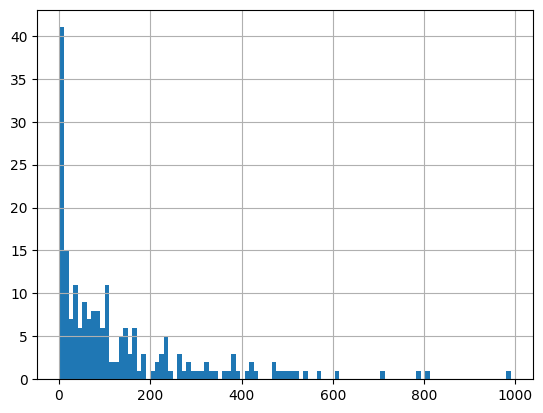

In [30]:
eBird_Taxonomy_v2021["count"].hist(bins=100)

In [34]:
eBird_Taxonomy_v2021.loc[eBird_Taxonomy_v2021["count"] < 20, "collection"].value_counts()

collection
XC      21
CSA     17
iNat    15
Name: count, dtype: int64

# Fix Duplicates

In [ ]:
def plot_n_spectograms_with_librosa(
    pathes,
    sr: int,
    n_mels: int,
    fmin: int,
    fmax: int,
    hop_length: int,
    n_fft: int,
    n_cols: int = 5,
    figsize: tuple = (5, 5),
    save_path: str = None,
):
    """
    Plot n spectograms from df using librosa
    """
    import librosa
    import librosa.display

    fig, axs = plt.subplots(
        len(pathes), 1, figsize=figsize, sharex=True, sharey=True
    )
    axs = axs.flatten()
    for i, path in enumerate(pathes):
        y, sr = librosa.load(f"/home/vova/data/exps/birdclef_2024/birdclef_2024/train_audio/{path}", sr=sr)
        D = librosa.amplitude_to_db(np.abs(librosa.stft(y, hop_length=hop_length)),ref=np.max)
        librosa.display.specshow(D, sr=sr, hop_length=hop_length,x_axis='time', ax=axs[i])
    plt.tight_layout()
    if save_path:
        plt.savefig(save_path)
    plt.show()

In [ ]:
train_metadata = pd.read_csv("/home/vova/data/exps/birdclef_2024/birdclef_2024/train_metadata_extended.csv")
train_metadata.head()

In [ ]:
def merge_duplicates(full_df, dupl_idxs, with_labels_merge=True):
    if len(dupl_idxs) > 2 and with_labels_merge:
        raise ValueError("Can not handle more than 2 dupls")
    dupl_df = full_df.loc[dupl_idxs]
    if with_labels_merge:
        dupl_df["all_labels"] = dupl_df["all_labels"].apply(eval)
        if len(dupl_df) < 2:
            import ipdb; ipdb.set_trace()
        if set(dupl_df["all_labels"].iloc[0]) != set(dupl_df["all_labels"].iloc[1]):
            dupl_df = dupl_df.sort_values("rating", ascending=False)
            full_df.loc[dupl_df.index[0], "secondary_labels"] = repr(list(set(
                eval(full_df.loc[dupl_df.index[0], "secondary_labels"]) +
                [full_df.loc[dupl_df.index[1], "primary_label"]] +
                eval(full_df.loc[dupl_df.index[1], "secondary_labels"])
            )))
            full_df.loc[dupl_df.index[0], "all_labels"] = repr(list(set(
                eval(full_df.loc[dupl_df.index[0], "all_labels"]) + eval(full_df.loc[dupl_df.index[1], "all_labels"])
            )))

        full_df = full_df.drop(index=[dupl_df.index[-1]])
    else:
        full_df = full_df.drop(index=dupl_df.index[1:])
    return full_df

In [ ]:
train_metadata["id"] = train_metadata["url"].apply(lambda x: x.split("/")[-1])

In [ ]:
id_vc = train_metadata["id"].value_counts()

In [ ]:
duplicated_id = id_vc[id_vc > 1].index

In [ ]:
for dupl_id in duplicated_id:
    print("\n\n\nBefore\n\n\n")
    print(train_metadata.loc[train_metadata["id"] == dupl_id, ["primary_label", "secondary_labels", "latitude", "longitude", "duration_s", "all_labels"]])
    train_metadata = merge_duplicates(train_metadata, train_metadata[train_metadata["id"] == dupl_id].index)
    print("\n\n\nAfter\n\n\n")
    print(train_metadata.loc[train_metadata["id"] == dupl_id, ["primary_label", "secondary_labels", "latitude", "longitude", "duration_s", "all_labels"]])

In [ ]:
train_metadata["id"].value_counts()

In [ ]:
train_metadata = train_metadata.reset_index(drop=True)

In [ ]:
my_duplicates = train_metadata.groupby(["duration_s", "author", "primary_label"])["filename"].apply(list).to_list()
my_duplicates = [el for el in my_duplicates if len(el) > 1]
len(my_duplicates)

In [ ]:
my_duplicates[187]

In [ ]:
for idx, dupl in enumerate(my_duplicates):
    print(f"Duplicate ID: {idx}")
    plot_n_spectograms_with_librosa(
        dupl,
        sr=None,
        n_mels=129,
        fmin=20,
        fmax=None,
        hop_length=512,
        n_fft=1024,
    )

In [ ]:
my_vis_dupl_indices = [
    0, 4, 6, 11, 14, 25, 27, 30, 31, 34, 37, 39, 40, 46, 52, 54, 58, 62, 63, 72, 77, 79, 
    81, 82, 85, 87, 90, 91, 92, 94, 95, 96, 101, 102, 103, 104, 105, 108, 111, 112, 114, 
    115, 116, 119, 120, 121, 124, 125, 126, 127, 128, 130, 133, 135, 136, 144, 147, 149, 
    151, 152, 154, 156, 157, 158, 159, 161, 162, 163, 165, 166, 167, 168, 169, 170, 171, 
    173, 175, 176, 178, 179, 180, 181, 182, 183, 184, 185, 187
]
my_duplicates_vis = [my_duplicates[idx] for idx in my_vis_dupl_indices]
my_duplicates_vis = [el for el in my_duplicates_vis if len(el) ==2]

In [ ]:
len(my_duplicates_vis)

In [ ]:
for idx, dupl in enumerate(my_duplicates_vis):
    print(f"Duplicate ID: {idx}")
    plot_n_spectograms_with_librosa(
        dupl,
        sr=None,
        n_mels=129,
        fmin=20,
        fmax=None,
        hop_length=512,
        n_fft=1024,
    )

In [ ]:
train_metadata.loc[train_metadata["filename"].isin(my_duplicates_vis[0]), ["primary_label", "secondary_labels", "latitude", "longitude", "duration_s", "all_labels"]]

In [ ]:
for dupl_fnames in my_duplicates_vis:
    print("\n\n\nBefore\n\n\n")
    print(train_metadata.loc[train_metadata["filename"].isin(dupl_fnames), ["primary_label", "secondary_labels", "latitude", "longitude", "duration_s", "all_labels"]])
    train_metadata = merge_duplicates(train_metadata, train_metadata[train_metadata["filename"].isin(dupl_fnames)].index)
    print("\n\n\nAfter\n\n\n")
    print(train_metadata.loc[train_metadata["filename"].isin(dupl_fnames), ["primary_label", "secondary_labels", "latitude", "longitude", "duration_s", "all_labels"]])

In [ ]:
train_metadata.head()

In [ ]:
orig_train_metadata = pd.read_csv(
    "/home/vova/data/exps/birdclef_2024/birdclef_2024/train_metadata_extended.csv"
)

In [ ]:
orig_train_metadata.shape[0] - train_metadata.shape[0]

In [ ]:
train_metadata["primary_label"].value_counts()

In [ ]:
train_metadata.to_csv("/home/vova/data/exps/birdclef_2024/birdclef_2024/train_metadata_extended_noduplv1.csv", index=False)

In [ ]:
train_metadata = pd.read_csv("/home/vova/data/exps/birdclef_2024/birdclef_2024/train_metadata_extended_noduplv2.csv")

add_data_prev_comp = pd.read_csv("/home/vova/data/exps/birdclef_2024/dfs/full_noduplsV3_scored_meta_prev_comps_extended_2024SecLabels.csv")
add_data_prev_comp["prev_comp_full"] = False

add_data_xc = pd.read_csv("/home/vova/data/exps/birdclef_2024/xeno_canto/dataset_2024_classes/train_metadata_noduplV4_extended_2024SecLabels.csv")

add_data_prev_comp_all = pd.read_csv("/home/vova/data/exps/birdclef_2024/dfs/full_noduplsV2_meta_prev_comps_extended.csv")
add_data_prev_comp_all["prev_comp_full"] = True

add_data_xc_massive = pd.read_csv("/home/vova/data/exps/birdclef_2024/xeno_canto/dataset_NO2024_classes/train_metadata_extended_india_vc50.csv")

# merged = pd.concat([train_metadata, add_data_prev_comp, add_data_xc]).reset_index(drop=True)
merged = pd.concat([train_metadata, add_data_xc, add_data_prev_comp, add_data_prev_comp_all, add_data_xc_massive]).reset_index(drop=True)

In [ ]:
add_data_xc_massive.shape

In [ ]:
add_data_xc_massive["dataset"]

In [ ]:
merged["dataset"].isna().sum(), (merged["dataset"] == "xc_2024_classes").sum(), (~merged["prev_comp_full"].fillna(True)).sum(), merged["prev_comp_full"].sum(),  (merged["dataset"] == "xc_india_vc50").sum()

In [ ]:
merged["id"] = merged["url"].apply(lambda x: x.split("/")[-1])
merged = merged.drop_duplicates("id").reset_index()
merged = merged.drop(columns=["id"])
merged["url"].apply(lambda x: x.split("/")[-1]).value_counts()

In [ ]:
merged["dataset"].isna().sum(), (merged["dataset"] == "xc_2024_classes").sum(), (~merged["prev_comp_full"].fillna(True)).sum(), merged["prev_comp_full"].sum(), (merged["dataset"] == "xc_india_vc50").sum()

In [ ]:
dupls = merged.groupby(["duration_s", "author", "primary_label", "latitude", "longitude"])["filename"].apply(list).to_list()
dupls = [el for el in dupls if len(el) > 1]

In [ ]:
len(dupls)

In [ ]:
train_metadat_fnames_set = set(train_metadata["filename"])
dupls = [el for el in dupls if not all(sub_el in train_metadat_fnames_set for sub_el in el)]
len(dupls)

In [ ]:
merged[merged["filename"].isin(dupls[-1])]

In [ ]:
for dupl_fnames in tqdm(dupls):
    merged = merge_duplicates(merged, merged[merged["filename"].isin(dupl_fnames)].index, with_labels_merge=False)


In [ ]:
merged[merged["filename"].isin(dupls[-1])]

In [ ]:
merged = merged.reset_index(drop=True)

In [ ]:
merged["dataset"].value_counts()

In [ ]:
merged["dataset"].isna().sum()

In [ ]:
new_train_metadata = merged[merged["dataset"].isna()].reset_index(drop=True)

new_add_data_prev_comp = merged[~merged["prev_comp_full"].fillna(True)].reset_index(drop=True)

new_add_data_prev_comp_all = merged[merged["prev_comp_full"].fillna(False)].reset_index(drop=True)

new_add_data_xc = merged[merged["dataset"] == "xc_2024_classes"].reset_index(drop=True)

new_add_data_xc_massive = merged[merged["dataset"] == "xc_india_vc50"].reset_index(drop=True)

In [ ]:
new_train_metadata.shape[0] - train_metadata.shape[0], new_add_data_prev_comp.shape[0] - add_data_prev_comp.shape[0], new_add_data_prev_comp_all.shape[0] - add_data_prev_comp_all.shape[0], new_add_data_xc.shape[0] - add_data_xc.shape[0], new_add_data_xc_massive.shape[0] - add_data_xc_massive.shape[0]

In [ ]:
# new_add_data_prev_comp = new_add_data_prev_comp[~new_add_data_prev_comp["url"].apply(lambda x: x.split("/")[-1]).isin(["590213", "316684"])].reset_index(drop=True)

In [ ]:
# new_add_data_xc.to_csv("/home/vova/data/exps/birdclef_2024/xeno_canto/dataset_2024_classes/train_metadata_noduplV4_extended_2024SecLabels.csv", index=False)

In [ ]:
new_add_data_prev_comp_all.drop(columns=["prev_comp_full"]).to_csv("/home/vova/data/exps/birdclef_2024/dfs/full_noduplsV4_meta_prev_comps_extended.csv", index=False)

In [ ]:
# new_add_data_xc.drop(columns=["prev_comp_full"]).to_csv("/home/vova/data/exps/birdclef_2024/xeno_canto/dataset_2024_classes/train_metadata_noduplV5_extended.csv", index=False)

In [ ]:
new_add_data_xc_massive.drop(columns=["prev_comp_full"]).to_csv("/home/vova/data/exps/birdclef_2024/xeno_canto/dataset_NO2024_classes/train_metadata_noduplV5_extended_india_vc50.csv", index=False)

In [ ]:
# new_add_data_prev_comp.to_csv("/home/vova/data/exps/birdclef_2024/dfs/full_noduplsV2_meta_prev_comps_extended_pruned.csv", index=False)
# add_data_xc.to_csv("/home/vova/data/exps/birdclef_2024/xeno_canto/dataset_2024_classes/train_metadata_noduplV3_extended.csv", index=False)

# Duplicates from [Discussion](https://www.kaggle.com/competitions/birdclef-2024/discussion/494134)

In [ ]:
train_metadata = pd.read_csv(
    "/home/vova/data/exps/birdclef_2024/birdclef_2024/train_metadata_extended_noduplv1.csv", 
    # converters={"secondary_labels":eval, "all_labels": eval}
)

In [ ]:
dupes = list({
    ("asbfly/XC347563.ogg", "asbfly/XC341611.ogg"),
    ("grewar3/XC507658.ogg", "grewar3/XC184040.ogg"),
    
    ('asbfly/XC724266.ogg', 'asbfly/XC724148.ogg'),
    ('barswa/XC575749.ogg', 'barswa/XC575747.ogg'),
    ('bcnher/XC669544.ogg', 'bcnher/XC669542.ogg'),
    ('bkskit1/XC350251.ogg', 'bkskit1/XC350249.ogg'),
    ('blhori1/XC417215.ogg', 'blhori1/XC417133.ogg'),
    ('blhori1/XC743616.ogg', 'blhori1/XC537503.ogg'),
    ('blrwar1/XC662286.ogg', 'blrwar1/XC662285.ogg'),
    ('brakit1/XC743675.ogg', 'brakit1/XC537471.ogg'),
    ('brcful1/XC197746.ogg', 'brcful1/XC157971.ogg'),
    ('brnshr/XC510751.ogg', 'brnshr/XC510750.ogg'),
    ('btbeat1/XC665307.ogg', 'btbeat1/XC513403.ogg'),
    ('btbeat1/XC743618.ogg', 'btbeat1/XC683300.ogg'),
    ('btbeat1/XC743619.ogg', 'btbeat1/XC683300.ogg'),
    ('btbeat1/XC743619.ogg', 'btbeat1/XC743618.ogg'),
    ('categr/XC787914.ogg', 'categr/XC438523.ogg'),
    ('cohcuc1/XC253418.ogg', 'cohcuc1/XC241127.ogg'),
    ('cohcuc1/XC423422.ogg', 'cohcuc1/XC423419.ogg'),
    ('comgre/XC202776.ogg', 'comgre/XC192404.ogg'),
    ('comgre/XC602468.ogg', 'comgre/XC175341.ogg'),
    ('comgre/XC64628.ogg', 'comgre/XC58586.ogg'),
    ('comior1/XC305930.ogg', 'comior1/XC303819.ogg'),
    ('comkin1/XC207123.ogg', 'comior1/XC207062.ogg'),
    ('comkin1/XC691421.ogg', 'comkin1/XC690633.ogg'),
    ('commyn/XC577887.ogg', 'commyn/XC577886.ogg'),
    ('commyn/XC652903.ogg', 'commyn/XC652901.ogg'),
    ('compea/XC665320.ogg', 'compea/XC644022.ogg'),
    ('comsan/XC385909.ogg', 'comsan/XC385908.ogg'),
    ('comsan/XC643721.ogg', 'comsan/XC642698.ogg'),
    ('comsan/XC667807.ogg', 'comsan/XC667806.ogg'),
    ('comtai1/XC126749.ogg', 'comtai1/XC122978.ogg'),
    ('comtai1/XC305210.ogg', 'comtai1/XC304811.ogg'),
    ('comtai1/XC542375.ogg', 'comtai1/XC540351.ogg'),
    ('comtai1/XC542379.ogg', 'comtai1/XC540352.ogg'),
    ('crfbar1/XC615780.ogg', 'crfbar1/XC615778.ogg'),
    ('dafbab1/XC188307.ogg', 'dafbab1/XC187059.ogg'),
    ('dafbab1/XC188308.ogg', 'dafbab1/XC187068.ogg'),
    ('dafbab1/XC188309.ogg', 'dafbab1/XC187069.ogg'),
    ('dafbab1/XC197745.ogg', 'dafbab1/XC157972.ogg'),
    ('eaywag1/XC527600.ogg', 'eaywag1/XC527598.ogg'),
    ('eucdov/XC355153.ogg', 'eucdov/XC355152.ogg'),
    ('eucdov/XC360303.ogg', 'eucdov/XC347428.ogg'),
    ('eucdov/XC365606.ogg', 'eucdov/XC124694.ogg'),
    ('eucdov/XC371039.ogg', 'eucdov/XC368596.ogg'),
    ('eucdov/XC747422.ogg', 'eucdov/XC747408.ogg'),
    ('eucdov/XC789608.ogg', 'eucdov/XC788267.ogg'),
    ('goflea1/XC163901.ogg', 'bladro1/XC163901.ogg'),
    ('goflea1/XC208794.ogg', 'bladro1/XC208794.ogg'),
    ('goflea1/XC208795.ogg', 'bladro1/XC208795.ogg'),
    ('goflea1/XC209203.ogg', 'bladro1/XC209203.ogg'),
    ('goflea1/XC209549.ogg', 'bladro1/XC209549.ogg'),
    ('goflea1/XC209564.ogg', 'bladro1/XC209564.ogg'),
    ('graher1/XC357552.ogg', 'graher1/XC357551.ogg'),
    ('graher1/XC590235.ogg', 'graher1/XC590144.ogg'),
    ('grbeat1/XC304004.ogg', 'grbeat1/XC303999.ogg'),
    ('grecou1/XC365426.ogg', 'grecou1/XC365425.ogg'),
    ('greegr/XC247286.ogg', 'categr/XC197438.ogg'),
    ('grewar3/XC743681.ogg', 'grewar3/XC537475.ogg'),
    ('grnwar1/XC197744.ogg', 'grnwar1/XC157973.ogg'),
    ('grtdro1/XC651708.ogg', 'grtdro1/XC613192.ogg'),
    ('grywag/XC459760.ogg', 'grywag/XC457124.ogg'),
    ('grywag/XC575903.ogg', 'grywag/XC575901.ogg'),
    ('grywag/XC650696.ogg', 'grywag/XC592019.ogg'),
    ('grywag/XC690448.ogg', 'grywag/XC655063.ogg'),
    ('grywag/XC745653.ogg', 'grywag/XC745650.ogg'),
    ('grywag/XC812496.ogg', 'grywag/XC812495.ogg'),
    ('heswoo1/XC357155.ogg', 'heswoo1/XC357149.ogg'),
    ('heswoo1/XC744698.ogg', 'heswoo1/XC665715.ogg'),
    ('hoopoe/XC631301.ogg', 'hoopoe/XC365530.ogg'),
    ('hoopoe/XC631304.ogg', 'hoopoe/XC252584.ogg'),
    ('houcro1/XC744704.ogg', 'houcro1/XC683047.ogg'),
    ('houspa/XC326675.ogg', 'houspa/XC326674.ogg'),
    ('inbrob1/XC744708.ogg', 'inbrob1/XC744706.ogg'),
    ('insowl1/XC305214.ogg', 'insowl1/XC301142.ogg'),
    ('junbab2/XC282587.ogg', 'junbab2/XC282586.ogg'),
    ('labcro1/XC267645.ogg', 'labcro1/XC265731.ogg'),
    ('labcro1/XC345836.ogg', 'labcro1/XC312582.ogg'),
    ('labcro1/XC37773.ogg', 'labcro1/XC19736.ogg'),
    ('labcro1/XC447036.ogg', 'houcro1/XC447036.ogg'),
    ('labcro1/XC823514.ogg', 'gybpri1/XC823527.ogg'),
    ('laudov1/XC185511.ogg', 'grewar3/XC185505.ogg'),
    ('laudov1/XC405375.ogg', 'laudov1/XC405374.ogg'),
    ('laudov1/XC514027.ogg', 'eucdov/XC514027.ogg'),
    ('lblwar1/XC197743.ogg', 'lblwar1/XC157974.ogg'),
    ('lewduc1/XC261506.ogg', 'lewduc1/XC254813.ogg'),
    ('litegr/XC403621.ogg', 'bcnher/XC403621.ogg'),
    ('litegr/XC535540.ogg', 'litegr/XC448898.ogg'),
    ('litegr/XC535552.ogg', 'litegr/XC447850.ogg'),
    ('litgre1/XC630775.ogg', 'litgre1/XC630560.ogg'),
    ('litgre1/XC776082.ogg', 'litgre1/XC663244.ogg'),
    ('litspi1/XC674522.ogg', 'comtai1/XC674522.ogg'),
    ('litspi1/XC722435.ogg', 'litspi1/XC721636.ogg'),
    ('litspi1/XC722436.ogg', 'litspi1/XC721637.ogg'),
    ('litswi1/XC443070.ogg', 'litswi1/XC440301.ogg'),
    ('lobsun2/XC197742.ogg', 'lobsun2/XC157975.ogg'),
    ('maghor2/XC197740.ogg', 'maghor2/XC157978.ogg'),
    ('maghor2/XC786588.ogg', 'maghor2/XC786587.ogg'),
    ('malpar1/XC197770.ogg', 'malpar1/XC157976.ogg'),
    ('marsan/XC383290.ogg', 'marsan/XC383288.ogg'),
    ('marsan/XC733175.ogg', 'marsan/XC716673.ogg'),
    ('mawthr1/XC455222.ogg', 'mawthr1/XC455211.ogg'),
    ('orihob2/XC557991.ogg', 'orihob2/XC557293.ogg'),
    ('piebus1/XC165050.ogg', 'piebus1/XC122395.ogg'),
    ('piebus1/XC814459.ogg', 'piebus1/XC792272.ogg'),
    ('placuc3/XC490344.ogg', 'placuc3/XC486683.ogg'),
    ('placuc3/XC572952.ogg', 'placuc3/XC572950.ogg'),
    ('plaflo1/XC615781.ogg', 'plaflo1/XC614946.ogg'),
    ('purher1/XC467373.ogg', 'graher1/XC467373.ogg'),
    ('purher1/XC827209.ogg', 'purher1/XC827207.ogg'),
    ('pursun3/XC268375.ogg', 'comtai1/XC241382.ogg'),
    ('pursun4/XC514853.ogg', 'pursun4/XC514852.ogg'),
    ('putbab1/XC574864.ogg', 'brcful1/XC574864.ogg'),
    ('rewbul/XC306398.ogg', 'bkcbul1/XC306398.ogg'),
    ('rewbul/XC713308.ogg', 'asbfly/XC713467.ogg'),
    ('rewlap1/XC733007.ogg', 'rewlap1/XC732874.ogg'),
    ('rorpar/XC199488.ogg', 'rorpar/XC199339.ogg'),
    ('rorpar/XC402325.ogg', 'comior1/XC402326.ogg'),
    ('rorpar/XC516404.ogg', 'rorpar/XC516402.ogg'),
    ('sbeowl1/XC522123.ogg', 'brfowl1/XC522123.ogg'),
    ('sohmyn1/XC744700.ogg', 'sohmyn1/XC743682.ogg'),
    ('spepic1/XC804432.ogg', 'spepic1/XC804431.ogg'),
    ('spodov/XC163930.ogg', 'bladro1/XC163901.ogg'),
    ('spodov/XC163930.ogg', 'goflea1/XC163901.ogg'),
    ('spoowl1/XC591485.ogg', 'spoowl1/XC591177.ogg'),
    ('stbkin1/XC266782.ogg', 'stbkin1/XC266682.ogg'),
    ('stbkin1/XC360661.ogg', 'stbkin1/XC199815.ogg'),
    ('stbkin1/XC406140.ogg', 'stbkin1/XC406138.ogg'),
    ('vefnut1/XC197738.ogg', 'vefnut1/XC157979.ogg'),
    ('vefnut1/XC293526.ogg', 'vefnut1/XC289785.ogg'),
    ('wemhar1/XC581045.ogg', 'comsan/XC581045.ogg'),
    ('wemhar1/XC590355.ogg', 'wemhar1/XC590354.ogg'),
    ('whbbul2/XC335671.ogg', 'whbbul2/XC335670.ogg'),
    ('whbsho3/XC856465.ogg', 'whbsho3/XC856463.ogg'),
    ('whbsho3/XC856468.ogg', 'whbsho3/XC856463.ogg'),
    ('whbsho3/XC856468.ogg', 'whbsho3/XC856465.ogg'),
    ('whbwat1/XC840073.ogg', 'whbwat1/XC840071.ogg'),
    ('whbwoo2/XC239509.ogg', 'rufwoo2/XC239509.ogg'),
    ('whcbar1/XC659329.ogg', 'insowl1/XC659329.ogg'),
    ('whiter2/XC265271.ogg', 'whiter2/XC265267.ogg'),
    ('whtkin2/XC197737.ogg', 'whtkin2/XC157981.ogg'),
    ('whtkin2/XC430267.ogg', 'whtkin2/XC430256.ogg'),
    ('whtkin2/XC503389.ogg', 'comior1/XC503389.ogg'),
    ('whtkin2/XC540094.ogg', 'whtkin2/XC540087.ogg'),
    ('woosan/XC184466.ogg', 'marsan/XC184466.ogg'),
    ('woosan/XC545316.ogg', 'woosan/XC476064.ogg'),
    ('woosan/XC587076.ogg', 'woosan/XC578599.ogg'),
    ('woosan/XC742927.ogg', 'woosan/XC740798.ogg'),
    ('woosan/XC825766.ogg', 'grnsan/XC825765.ogg'),
    ('zitcis1/XC303866.ogg', 'zitcis1/XC302781.ogg'),
})

In [ ]:
while len(dupes) > 0:
    dupe = dupes.pop()
    if train_metadata["filename"].isin(dupe).sum() > 1:
        print("Dropping: ", dupe)
        train_metadata = merge_duplicates(
            train_metadata, 
            train_metadata[train_metadata["filename"].isin(dupe)].index, 
            with_labels_merge=True
        )

In [ ]:
train_metadata = train_metadata.reset_index(drop=True)

In [ ]:
train_metadata["primary_label"].value_counts()

In [ ]:
train_metadata.to_csv(
    "/home/vova/data/exps/birdclef_2024/birdclef_2024/train_metadata_extended_noduplv2.csv",
    index=False
)

# Create Merged dataset

In [ ]:
train_metadata = pd.read_csv("/home/vova/data/exps/birdclef_2024/birdclef_2024/train_metadata_extended_noduplv2.csv")

add_data_prev_comp = pd.read_csv("/home/vova/data/exps/birdclef_2024/dfs/full_noduplsV3_scored_meta_prev_comps_extended_2024SecLabels.csv")

add_data_xc = pd.read_csv("/home/vova/data/exps/birdclef_2024/xeno_canto/dataset_2024_classes/train_metadata_noduplV4_extended_2024SecLabels.csv")

In [ ]:
train_metadata["dataset"] = "base"

In [ ]:
merged_data = pd.concat([train_metadata, add_data_prev_comp, add_data_xc]).reset_index(drop=True)

In [ ]:
merged_data.to_csv(
    "/home/vova/data/exps/birdclef_2024/birdclef_2024/merged_train_metadata_extended_noduplv2.csv", index=False
)

# Handling one sample classes

In [ ]:
def add_postfix(input, postfix):
    base, ext = os.path.splitext(input)
    return base + postfix + ext

In [ ]:
one_sample_classes = train_metadata_nodupl["primary_label"].value_counts().iloc[-7:].index

In [ ]:
one_sample_df = train_metadata_nodupl[train_metadata_nodupl["primary_label"].isin(one_sample_classes)].reset_index(drop=True)

one_sample_df_1 = one_sample_df.copy()
one_sample_df_2 = one_sample_df.copy()

one_sample_df_1["filename"] = one_sample_df_1["filename"].apply(lambda x: add_postfix(x, "_1"))
one_sample_df_2["filename"] = one_sample_df_2["filename"].apply(lambda x: add_postfix(x, "_2"))

one_sample_df_ext = pd.concat([one_sample_df_1, one_sample_df_2])

In [ ]:
one_sample_df_ext["filename"].apply(lambda x: os.path.join("/home/vova/data/exps/BirdCLEF_2023/birdclef_2023/train_audio/", x)).to_list()

In [ ]:
train_audio_samples = parallel_librosa_load(
    one_sample_df_ext["filename"].apply(lambda x: os.path.join("/home/vova/data/exps/BirdCLEF_2023/birdclef_2023/train_audio/", x)).to_list(), 
    return_sr=False, 
    sr=None
)
sample_rates = parallel_librosa_load(
    one_sample_df_ext["filename"].apply(lambda x: os.path.join("/home/vova/data/exps/BirdCLEF_2023/birdclef_2023/train_audio/", x)).to_list(), 
    return_audio=False, 
    sr=None
)

In [ ]:
one_sample_df_ext["duration_s"] = [len(au_) / sr_ for au_, sr_ in zip(train_audio_samples, sample_rates)]

In [ ]:
train_metadata_nodupl_split_1sample = train_metadata_nodupl.copy()
train_metadata_nodupl_split_1sample = train_metadata_nodupl_split_1sample[~train_metadata_nodupl_split_1sample["primary_label"].isin(one_sample_classes)].reset_index(drop=True)
train_metadata_nodupl_split_1sample = pd.concat([train_metadata_nodupl_split_1sample, one_sample_df_ext]).reset_index(drop=True)

In [ ]:
add_data = pd.read_csv("/home/vova/data/exps/BirdCLEF_2023/train_metadata_extended_2020_2022_no2023_scored.csv", converters={"all_labels": eval})

In [ ]:
train_metadata_nodupl.loc[
    train_metadata_nodupl["primary_label"].isin(set(list(chain(*add_data["all_labels"].to_list())))), 
    "primary_label"
].value_counts()

In [ ]:
train_metadata_nodupl_split_1sample.to_csv("/home/vova/data/exps/BirdCLEF_2023/birdclef_2023/train_metadata_extended_nodupl_v1_1SampleSplitV1.csv", index=False)

In [ ]:
train_metadata_nodupl_split_1sample["primary_label"].value_counts()

# Check 2 Previous steps

In [ ]:
new_df = pd.read_csv("/home/vova/data/exps/BirdCLEF_2023/birdclef_2023/train_metadata_extended_nodupl_v1_1SampleSplitV1.csv")
old_df = pd.read_csv("/home/vova/data/exps/BirdCLEF_2023/birdclef_2023/train_metadata_extended.csv")

In [ ]:
duplicates = load_json("/home/vova/data/exps/BirdCLEF_2023/birdclef_2023/duplicates_v1.json")

# Test Audio Data

In [ ]:
ipd.Audio("/home/vova/data/exps/BirdCLEF_2023/birdclef_2023/test_soundscapes/soundscape_29201.ogg")

In [ ]:
test_au, test_sr = librosa.load("/home/vova/data/exps/BirdCLEF_2023/birdclef_2023/test_soundscapes/soundscape_29201.ogg", sr=None)

In [ ]:
len(test_au) / test_sr, test_sr

# Train Audio 

In [ ]:
train_samples = glob("/home/vova/data/exps/birdclef_2024/birdclef_2024/train_audio/*/*.ogg", recursive=True)

In [ ]:
sample_rates = parallel_librosa_load(
    train_samples, 
    return_audio=False, 
    sr=None
)

In [ ]:
train_audio_samples = parallel_librosa_load(
    train_samples, 
    return_sr=False, 
    sr=None
)

In [ ]:
np.unique(sample_rates)

In [ ]:
train_audio_samples_lens = [len(au_) / sr_ for au_, sr_ in zip(train_audio_samples, sample_rates)]
plt.hist(train_audio_samples_lens, bins=30);

In [ ]:
def get_filename(path):
    return "/".join(path.split("/")[-2:])

audio_info = pd.DataFrame({
    "filename":[get_filename(el) for el in train_samples],
    "duration_s":train_audio_samples_lens
})

audio_info

In [ ]:
(audio_info["duration_s"] < 30).sum() / audio_info.shape[0]

In [ ]:
train_metadata = train_metadata.merge(audio_info, on="filename")
train_metadata

In [ ]:
train_metadata.url.value_counts()

In [ ]:
train_metadata[train_metadata.url == "https://www.xeno-canto.org/514027"]

In [ ]:
train_metadata.loc[9245, "secondary_labels"] = ["laudov1"]
train_metadata = train_metadata.drop(index=[16259]).reset_index(drop=True)

In [ ]:
train_metadata[train_metadata.url == "https://www.xeno-canto.org/514027"]

In [ ]:
train_metadata['all_labels'] = train_metadata.apply(lambda x: [x["primary_label"]] + x["secondary_labels"], axis=1)

In [ ]:
train_metadata.to_csv("/home/vova/data/exps/birdclef_2024/birdclef_2024/train_metadata_extended.csv", index=False)

# Secondary Labels

In [ ]:
train_metadata["secondary_labels"] = train_metadata["secondary_labels"].apply(eval)

In [ ]:
secondary_labels_unique = set(list(chain(*train_metadata["secondary_labels"].to_list())))

In [ ]:
secondary_labels_unique - set(train_metadata["primary_label"])

In [ ]:
set(train_metadata["primary_label"]) - secondary_labels_unique

# Metric

In [ ]:
!pip list | grep scikit

In [ ]:
from sklearn.metrics import roc_auc_score

In [ ]:
def adjust_classes(array):
    """ Adjust the array to ensure no column has only one class present.
    
    Args:
    array (np.ndarray): The input array of shape (N_rows, N_classes).
    
    Returns:
    np.ndarray: The adjusted array.
    """
    # Iterate over each column in the array
    for col_idx in range(array.shape[1]):
        if np.all(array[:, col_idx] == 1):
            # If all values in the column are 1, randomly select one row to change to 0
            row_to_change = np.random.choice(array.shape[0])
            array[row_to_change, col_idx] = 0
            
    return array

def score(solution: pd.DataFrame, submission: pd.DataFrame, row_id_column_name: str = "row_id") -> float:
    '''
    Version of macro-averaged ROC-AUC score that ignores all classes that have no true positive labels.
    '''
    del solution[row_id_column_name]
    del submission[row_id_column_name]

    solution_sums = solution.sum(axis=0)
    scored_columns = list(solution_sums[solution_sums > 0].index.values)
    assert len(scored_columns) > 0

    return roc_auc_score(
        y_true=solution[scored_columns].values,
        y_score=submission[scored_columns].values,
        average="macro"
    )

def score_numpy(y_true: np.ndarray, y_pred: np.ndarray):
    scored_columns_mask = y_true.sum(axis=0) > 0

    y_true_filtered = y_true.T[scored_columns_mask].T
    y_pred_filtered = y_pred.T[scored_columns_mask].T

    return roc_auc_score(
        y_true=y_true_filtered,
        y_score=y_pred_filtered,
        average="macro"
    )

In [ ]:
sample_solution = sample_submission.copy()
sample_solution[[col for col in sample_solution.columns if col != "row_id"]] = adjust_classes(np.random.randint(
    0,
    2, 
    size=sample_solution[[col for col in sample_solution.columns if col != "row_id"]].shape
))

In [ ]:
score(
    solution=sample_solution.copy(),
    submission=sample_submission.copy(),
)

In [ ]:
score(
    solution=sample_solution.copy(),
    submission=sample_solution.copy(),
)

In [ ]:
score_numpy(
    y_true=sample_solution[[col for col in sample_submission.columns if col != "row_id"]].values,
    y_pred=sample_solution[[col for col in sample_solution.columns if col != "row_id"]].values
)

In [ ]:
score_numpy(
    y_true=sample_solution[[col for col in sample_submission.columns if col != "row_id"]].values,
    y_pred=sample_submission[[col for col in sample_solution.columns if col != "row_id"]].values
)

# Sample Weights

In [ ]:
# sample_weights = train_metadata["primary_label"].value_counts()

In [ ]:
sample_weights = (train_metadata["primary_label"].value_counts() / train_metadata["primary_label"].value_counts().sum())  ** (-0.5)

In [ ]:
write_json("/home/vova/data/exps/birdclef_2024/sample_weights/sw_2024_v1.json", sample_weights.to_dict())

# CV Split

In [ ]:
cv_split = np.load("/home/vova/data/exps/birdclef_2024/cv_splits/birdclef_2024_5_folds_split.npy", allow_pickle=True)

In [ ]:
len(set(train_metadata["primary_label"]))

## CV Split Precise Check

In [ ]:
cv_split = np.load("/home/vova/data/exps/birdclef_2024/cv_splits/birdclef_2024_5_folds_split.npy", allow_pickle=True)
df = pd.read_csv("/home/vova/data/exps/birdclef_2024/birdclef_2024/train_metadata.csv")

In [ ]:
all_classes = set(df["primary_label"])
len(all_classes)

In [ ]:
for fold_id, (train_idx, val_idx) in enumerate(cv_split):
    assert len(set(df["filename"].iloc[val_idx]) & set(df["filename"].iloc[train_idx])) == 0, fold_id
    assert set(df["primary_label"].iloc[train_idx]) == all_classes, fold_id

# Create Fake Test Data

In [ ]:
file_to_copy = "/home/vova/data/exps/BirdCLEF_2023/birdclef_2023/test_soundscapes/soundscape_29201.ogg"

In [ ]:
for i in range(20):
    copyfile(
        file_to_copy,
        f"/home/vova/data/exps/BirdCLEF_2023/kaggle_datasets/bird_clef_2023_addones/fake_test_20/fake_test_file_{i}.ogg"
    )